In [ ]:
from mylib.statistic_test import *
from sklearn.decomposition import PCA
from mazepy.datastruc.neuact import SpikeTrain
from mazepy.datastruc.variables import VariableBin

code_id = "0850 - Lisa Paper Revisits"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)


def get_lapwise_ratemap(trace: dict, is_cutted: bool = True):    
    maze_type = trace['maze_type']
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx, maze_type)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    
    for i in range(beg_idx.shape[0]):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes)
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T
    
    if is_cutted:
        bins = CP_DSPs[maze_type][3]-1
        smoothed_map = smoothed_map[:, bins, :]

    X = np.transpose(smoothed_map, (2, 1, 0))
    return X

def get_all_mice_data(mouse):
    file_indices = np.where(f2['MiceID'] == mouse)[0]
    cellreg_index = np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]
    maze_type = f2['maze_type'][file_indices[0]]
    
    traces = []
    for i in file_indices:
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
            traces.append(trace)

    with open(f_CellReg_dsp['cellreg_folder'][cellreg_index], 'rb') as handle:
        index_map = pickle.load(handle).astype(np.int64)
            
    if mouse != 10232:
        index_map = index_map[1:, :]
    
    # Identify neurons that appear in all sessions
    ncell = np.where(np.sum(np.where(index_map == 0, 0, 1), axis=0) == index_map.shape[0])[0]
    
    session_label = []
    route_label = []
    Xs = []
    centroid_init0 = []
    centroid_init1 = []
    for i, trace in enumerate(traces):
        X = get_lapwise_ratemap(trace)
        
        cent1 = trace[f'node 3']['old_map_clear'][index_map[i, ncell]-1, :][:, CP_DSPs[maze_type][3]-1].T.flatten()
        cent0 = np.vstack([trace[f'node {n}']['old_map_clear'][index_map[i, ncell]-1, :][:, CP_DSPs[maze_type][3]-1].T.flatten() for n in [0, 4, 5, 9]])
        cent0 = np.mean(cent0, axis=0)
        
        centroid_init0.append(cent0)
        centroid_init1.append(cent1)
        
        beg_time, end_time = trace['lap beg time'], trace['lap end time']
        beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx, maze_type)
        Xs.append(X[:, :, index_map[i, ncell]-1])
        
        session_label.append(np.ones(X.shape[0])*i)
        route_label.append(routes)
    
    return np.concatenate(Xs, axis=0), np.concatenate(session_label), np.concatenate(route_label), [centroid_init0, centroid_init1]

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\Dsp\0850 - Lisa Paper Revisits is already existed!


In [ ]:
from sklearn.cluster import KMeans

def fit_kmeans(X, R: int, kmeans_init=None, is_return_model: bool = False):
    """
    Cluster Maps with KMeans model.
    
    Parameters
    ----------
    X : np.ndarray
        The entire map of this cell within this session.
        shape: (I x J x K) tensor of normalized firing rates
        
        I: Trials
        J: Spatial bins
        K: Neurons
    
    Returns
    -------
    U, V
    """
    X_wrap = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    
    if kmeans_init is not None:
        kmean = KMeans(n_clusters=R, init=kmeans_init)
    else:
        kmean = KMeans(n_clusters=R)
        
    kmean.fit(X_wrap)
    
    U = np.zeros((X.shape[0], R))
    for i in range(X.shape[0]):
        U[i, kmean.labels_[i]] = 1
        
    V = kmean.cluster_centers_
    
    if R == 2 and is_return_model == False:
        nclusters = np.sum(U, axis=0)
        if nclusters[0] < nclusters[1]:
            print(f"{nclusters[0]} < {nclusters[1]}")
            U = U[:, [1, 0]]
            V = V[[1, 0], :]
    
    if is_return_model:
        return U, V, kmean
    else:
        return U, V

def fit_pca(X, n_components: int, kmeans_init=None):
    """
    Cluster Maps with KMeans model.
    
    Parameters
    ----------
    X : np.ndarray
        The entire map of this cell within this session.
        shape: (I x J x K) tensor of normalized firing rates
        
        I: Trials
        J: Spatial bins
        K: Neurons
        
    n_components: int
        Number of components to keep
    
    Returns
    -------
    reduced_X: np.ndarray
        The reduced map, shape: (I x n_components)
    """
    X_wrap = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    
    pca = PCA(n_components=n_components)
    
    if kmeans_init is None:
        return pca.fit_transform(X_wrap)
    else:
        pca.fit(X_wrap)
        return pca.transform(X_wrap), pca.transform(kmeans_init)

def get_lap_distances(X, V):
    """
    Refer to 'Distance to cluster calculations' Section of Lisa paper.
    
    Parameters
    ----------
    X: ndarray (I x J x K) tensor of normalized firing rates
        I: Trials/Laps
        J: Position Bins
        K: Neurons
    V: ndarray, low-dimensional factors (R x JK)
        R: Rank, which is 2 here
    
    Returns
    -------
    Distances: ndarray, distances to cluster centers (I x R), for each position
    in each lap.
    """
    I, J, K = X.shape
    V = V.reshape(2, J, K)
    
    Distances = np.zeros(I)
    
    for i in range(I):
        Distances[i] = (
            np.sum(
                (2 * X[i, :, :] - (V[0, :, :] + V[1, :, :])) * 
                (V[0, :, :] - V[1, :, :])
            ) / 
            np.sum((V[0, :, :] - V[1, :, :])**2)
        )
            
    return Distances

def get_lap_neuron_distances(X, V):
    """
    Refer to 'Distance to cluster calculations' Section of Lisa paper.
    
    Parameters
    ----------
    X: ndarray (I x J x K) tensor of normalized firing rates
        I: Trials/Laps
        J: Position Bins
        K: Neurons
    V: ndarray, low-dimensional factors (R x JK)
        R: Rank, which is 2 here
    
    Returns
    -------
    Distances: ndarray, distances to cluster centers (I x R), for each neuron
    in each lap.
    and 
    """
    I, J, K = X.shape
    V = V.reshape(2, J, K)
    
    Distances = np.zeros((I, K))
    
    for i in range(I):
        for k in range(K):
            Distances[i, k] = (
                np.sum(
                    (2 * X[i, :, k] - (V[0, :, k] + V[1, :, k])) * 
                    (V[0, :, k] - V[1, :, k])
                ) / 
                np.sum((V[0, :, k] - V[1, :, k])**2)
            )
            
    return Distances

def _convert_pos_to_idx(P):
    converting_array = np.zeros(144)-1
    for i, pos in enumerate(CP_DSPs[1][3]):
        converting_array[pos-1] = i
        
    return converting_array[P-1].astype(np.int64)

def get_lap_pos_distances(X, P, V):
    """
    Refer to 'Distance to cluster calculations' Section of Lisa paper.
    
    Parameters
    ----------
    X: ndarray (N x T) matrix of firing rates, i.e., neural trajectory
        N: Neurons
        T: Time bins
    P: ndarray (T, ) array of positions, corresponding to each time bin.
    
    V: ndarray, low-dimensional factors (R x JK)
        R: Rank, which is 2 here
    
    Returns
    -------
    Distances: ndarray, distances to cluster centers (I x R), for each position
    in each lap.
    """
    N, T = X.shape
    V = V.reshape(2, CP_DSPs[1][3].shape[0], N)
    
    P = _convert_pos_to_idx(P)
    
    kmeans_dist_traj = np.zeros(T)
    
    for t in range(T):
        if P[t] == -1:
            kmeans_dist_traj[t] = np.nan
            continue
        """
        projection = np.dot(X[:, t] - (V[0, P[t], :] + V[1, P[t], :]) / 2, V[0, P[t], :] - V[1, P[t], :])
        projection /= np.linalg.norm(V[0, P[t], :] - V[1, P[t], :])**2
        kmeans_dist_traj[t] = projection
        """
        kmeans_dist_traj[t] = (
            np.sum(
                (2 * X[:, t] - (V[0, P[t], :] + V[1, P[t], :])) * 
                (V[0, P[t], :] - V[1, P[t], :])
            ) / 
            np.sum((V[0, P[t], :] - V[1, P[t], :])**2)
        )
        
    return kmeans_dist_traj


def plot_lapwise_distances(X, session_label, route_label, mouse, kmeans_init = None):
    U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
    print(np.where(V<0)[0].shape[0])
    distances = get_lap_distances(X, V)

    y_max = 2
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(7, 4))
    for i in range(7):
        ax = Clear_Axes(axes[i], close_spines=['left', 'top', 'right'], ifxticks=True)
        idx = np.where(session_label == i)[0]
        ax.plot(
            distances[idx],
            np.arange(idx.shape[0]), 
            linewidth=0.5,
            color='#B5B5B6' #gray
        )
        idx0 = np.where(
            distances[idx] > 0
        )[0]
        idx1 = np.where(
            distances[idx] < 0
        )[0]
        ax.plot( 
            distances[idx][idx0], 
            np.arange(idx.shape[0])[idx0],
            's',
            markeredgewidth=0,
            markersize=2.5,
            linewidth=0.5,
            color='#28306E'
        )
        ax.plot(
            distances[idx][idx1], 
            np.arange(idx.shape[0])[idx1],
            's',
            markeredgewidth=0,
            markersize=2.5,
            linewidth=0.5,
            color='#A2C78D'
        )
    
        for j in range(7):
            idxr = np.where(route_label[idx] == j)[0]
            ax.plot(
                np.repeat(2.4, idxr.shape[0]),
                np.arange(idx.shape[0])[idxr], 
                's',
                markeredgewidth=0,
                markersize=3,
                color=DSPPalette[j]
            )
    
        dl = np.where(np.ediff1d(route_label[idx]) != 0)[0] + 0.5
        for d in dl:
            ax.axhline(d, color='k', linewidth=0.1, ls='--')
    
        ax.axvline(0, color='k', linewidth=0.1, ls='--')
        ax.set_xlim([y_max+0.5, -y_max])
        ax.set_xticks(np.linspace(-2, 2, 5)) 
    plt.savefig(join(loc, f"DistanceToCluster {mouse}.png"), dpi = 600)
    plt.savefig(join(loc, f"DistanceToCluster {mouse}.svg"), dpi = 600)
    plt.show()

def hex_to_rgba(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-255).
    """
    hex_color = hex_color.lstrip('#')  # Remove '#' if present
    if len(hex_color) == 6:
        r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
        a = 255  # Default alpha
    elif len(hex_color) == 8:
        r, g, b, a = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16), int(hex_color[6:8], 16)
    else:
        raise ValueError("Invalid hex color format. Use #RRGGBB or #RRGGBBAA.")
    return r, g, b, a

def hex_to_rgba_normalized(hex_color):
    """
    Convert a hex color (#RRGGBB or #RRGGBBAA) to RGBA format (0-1).
    """
    r, g, b, a = hex_to_rgba(hex_color)
    return np.array([r / 255, g / 255, b / 255, a / 255])

DSPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in DSPPalette])
DayPaletteRGBA = np.asarray(sns.color_palette("rainbow", 7))
MAPPaletteRGBA = np.vstack([hex_to_rgba_normalized(c) for c in ['#333766', '#A4C096']])

def plot_pca_clusters(X, session_label, route_label, mouse, map_identity, kmeans_init = None):
    if kmeans_init is None:
        reduced_X = fit_pca(X, 2)
    else:
        reduced_X, reduced_centroids = fit_pca(X, 2, kmeans_init=kmeans_init)
        
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(3, 9))
    ax0, ax1, ax2 = (
        Clear_Axes(axes[0], close_spines=['top', 'right']), 
        Clear_Axes(axes[1], close_spines=['top', 'right']), 
        Clear_Axes(axes[2], close_spines=['top', 'right'])
    )
    ax0.scatter(
        reduced_X[:, 0],
        reduced_X[:, 1],
        s=5,
        color=DSPPaletteRGBA[route_label, :],
        alpha=0.9
    )
    ax1.scatter(
        reduced_X[:, 0],
        reduced_X[:, 1],
        s=5,
        alpha=0.9,
        color=DayPaletteRGBA[session_label.astype(np.int64), :]
    )
    
    if kmeans_init is not None:
        ax0.scatter(
            reduced_centroids[:, 0],
            reduced_centroids[:, 1],
            s=10,
            color=MAPPaletteRGBA
        )
        ax1.scatter(
            reduced_centroids[:, 0],
            reduced_centroids[:, 1],
            s=10,
            color=MAPPaletteRGBA
        )
        
    ax0.set_aspect("equal")
    ax1.set_aspect("equal")
    # Blues correspond to Session 0 while reds correspond to Session 6
    ax2.scatter(
        reduced_X[:, 0],
        reduced_X[:, 1],
        s=5,
        color=MAPPaletteRGBA[map_identity.astype(np.int64), :],
        alpha=0.9
    )
    ax2.set_aspect("equal")
    plt.savefig(join(loc, f"PCA Clusters {mouse}.png"), dpi = 600)
    plt.savefig(join(loc, f"PCA Clusters {mouse}.svg"), dpi = 600)
    plt.show()
    
def plot_pca_centroid_evolution(
    X: np.ndarray, 
    session_label: np.ndarray, 
    route_label: np.ndarray, 
    mouse: int, 
    map_identity: np.ndarray, 
    kmeans_init: list[np.ndarray, np.ndarray] | None = None
):
    reduced_X = fit_pca(X, 2)
        
    fig = plt.figure(figsize=(3, 3))
    ax0 = Clear_Axes(plt.axes(), close_spines=['top', 'right'])
    centroids_x_m0 = np.array([
        np.nanmean(reduced_X[np.where((session_label == s) & (map_identity == 0))[0], 0]) for s in range(7)
    ])
    centroids_y_m0 = np.array([
        np.nanmean(reduced_X[np.where((session_label == s) & (map_identity == 0))[0], 1]) for s in range(7)
    ])
    
    centroids_x_m1 = np.array([
        np.nanmean(reduced_X[np.where((session_label == s) & (map_identity == 1))[0], 0]) for s in range(7)
    ])
    centroids_y_m1 = np.array([
        np.nanmean(reduced_X[np.where((session_label == s) & (map_identity == 1))[0], 1]) for s in range(7)
    ])
    print(centroids_x_m0, centroids_y_m0)
    print(centroids_x_m1, centroids_y_m1)

    ax0.scatter(
        centroids_x_m0,
        centroids_y_m0,
        s=40,
        color=sns.color_palette("rainbow", 7),
        edgecolor=None,
        alpha=0.8,
        linewidth=1
    )
    ax0.scatter(
        centroids_x_m1,
        centroids_y_m1,
        s=40,
        marker='s',
        color=sns.color_palette("rainbow", 7),
        edgecolor=None,
        alpha=0.8,
        linewidth=1
    )

    if mouse == 10212:
        ax0.plot(            
            centroids_x_m0[np.isnan(centroids_x_m0) == False],
            centroids_y_m0[np.isnan(centroids_y_m0) == False],
            color='k',
            linewidth=0.5
        )
    else:
        ax0.plot(
            centroids_x_m0,
            centroids_y_m0,
            color='k',
            linewidth=0.5
        )
        
    ax0.plot(
        centroids_x_m1,
        centroids_y_m1,
        color='k',
        linewidth=0.5
    )
        
    plt.savefig(join(loc, f"PCA Centroid Evolution {mouse}.png"), dpi = 600)
    plt.savefig(join(loc, f"PCA Centroid Evolution {mouse}.svg"), dpi = 600)
    plt.show()

(549, 27, 118)


e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\12454\AppData\Local\Temp\ipykernel_26012\1238559338.py:360: RuntimeWarning: Mean of empty slice
  np.nanmean(reduced_X[np.where((session_label == s) & (map_identity == 0))[0], 0]) for s in range(7)
C:\Users\12454\AppData\Local\Temp\ipykernel_26012\1238559338.py:363: RuntimeWarning: Mean of empty slice
  np.nanmean(reduced_X[np.where((session_label == s) & (map_identity == 0))[0], 1]) for s in range(7)


[-40.72772029          nan -43.21683869 -56.64819057 -55.01772543
 -60.55502724 -46.88718731] [ -9.94862416          nan  -7.28396664  -8.35553859  -8.5721847
 -11.20202838  -9.4015559 ]
[ 13.42189352  11.59251002  13.56439451  13.05803575  23.1773136
   8.07967005 -17.66624851] [-33.48046587 -31.18448034 -18.80693471  -0.59236436  19.52408699
  24.78029247  24.93581116]


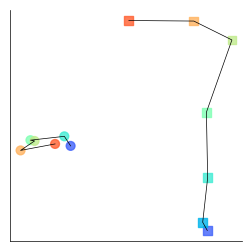

(667, 27, 144)
[-39.21269925 -49.07992158 -52.39541472 -54.71149488 -61.78871749
 -66.77531215 -66.61848558] [ -0.02829339  -2.98936534  -4.89628962  -6.77630633 -11.57005191
 -13.98570083 -11.21383626]
[15.45273691 21.19251132 24.1950784  20.52194845 13.44817088  6.60259587
  1.41389837] [-29.78683868 -32.63976719 -16.87221371   8.0533152   18.39521305
  26.99683486  33.0324208 ]


e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


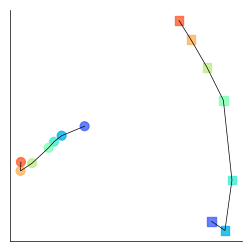

(619, 27, 302)


e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


[-40.29772277 -36.41267583 -54.12693144 -54.6293812  -70.29099308
 -76.93062717 -78.21807423] [-2.0829865  -6.04445068  3.50408171  4.20504393  2.86852039  1.82594863
  2.41729922]
[ 3.98486778  8.19779676 11.2892809  17.8713064  12.45809581 14.82193366
 11.04540325] [-34.52914895 -28.586624   -11.78691149  -2.74295731  12.42696829
  29.31182067  26.6229812 ]


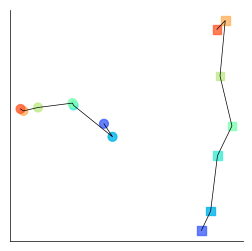

(776, 27, 261)
[-52.43398934 -58.51882232 -66.43859505 -74.72383604 -65.92712684
 -73.99074491 -77.2111999 ] [0.60822033 0.59778767 4.32503795 7.68082491 5.71346708 7.56616748
 9.46536323]
[13.28596783  4.02361395 13.67139753 20.08013552 12.18881791 26.29797237
 26.47110476] [-37.44957733 -31.18858715 -23.33626247 -11.26756004  11.46422172
  25.10593861  40.74257262]


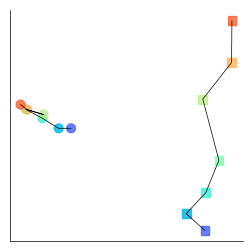

In [3]:
for mouse in [10212, 10224, 10227, 10232]:
    with open(join(loc, f"{mouse}.pkl"), "rb") as f:
        X, session_label, route_label, kmeans_init = pickle.load(f)
    print(X.shape)
    kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
    U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)

    plot_pca_centroid_evolution(X, session_label, route_label, mouse, U[:, 0])

# Reversed Map transition Frequency

In [4]:
transition_sessions = []
for mouse in [10212, 10224, 10227, 10232]:
    with open(join(loc, f"{mouse}.pkl"), "rb") as f:
        X, session_label, route_label, kmeans_init = pickle.load(f)

    kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
    U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
    
    for r in [0, 1, 2, 4, 5]:
        print(f"Mouse {mouse}, Route {r}:     {np.where((U[:, 0] == 0)&(route_label == r))[0].shape[0]}/{np.where((route_label == r))[0].shape[0]}    {U.shape[0]}")
    print(f"{[np.where((U[:, 0] == 0)&(route_label == 6)&(session_label == s))[0].shape[0] for s in np.arange(7)]}/{[np.where((route_label == 6)&(session_label == s))[0].shape[0] for s in np.arange(7)]}")
    print(f"{[np.where((U[:, 0] == 1)&(route_label == 6)&(session_label == s))[0].shape[0] for s in np.arange(7)]}/{[np.where((route_label == 6)&(session_label == s))[0].shape[0] for s in np.arange(7)]}")

e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Mouse 10212, Route 0:     0/221    549
Mouse 10212, Route 1:     0/54    549
Mouse 10212, Route 2:     0/53    549
Mouse 10212, Route 4:     1/54    549
Mouse 10212, Route 5:     2/54    549
[1, 0, 1, 1, 2, 9, 10]/[6, 6, 7, 10, 8, 10, 10]
[5, 6, 6, 9, 6, 1, 0]/[6, 6, 7, 10, 8, 10, 10]
Mouse 10224, Route 0:     0/261    667
Mouse 10224, Route 1:     0/68    667
Mouse 10224, Route 2:     0/67    667
Mouse 10224, Route 4:     0/65    667
Mouse 10224, Route 5:     0/68    667
[5, 9, 10, 10, 13, 10, 10]/[8, 9, 10, 10, 13, 10, 10]
[3, 0, 0, 0, 0, 0, 0]/[8, 9, 10, 10, 13, 10, 10]
Mouse 10227, Route 0:     1/243    619
Mouse 10227, Route 1:     0/62    619
Mouse 10227, Route 2:     0/61    619
Mouse 10227, Route 4:     0/62    619
Mouse 10227, Route 5:     0/64    619
[0, 1, 0, 7, 8, 9, 9]/[8, 9, 9, 9, 10, 10, 9]
[8, 8, 9, 2, 2, 1, 0]/[8, 9, 9, 9, 10, 10, 9]
Mouse 10232, Route 0:     1/304    776
Mouse 10232, Route 1:     0/80    776
Mouse 10232, Route 2:     1/79    776
Mouse 10232, Route 4: 

# Identify if Two Maps demonstrate data best

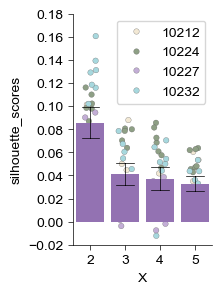

  Mean: 0.08575400616014188, STD: 0.03498278701680878, Max: 0.16060504796062286, Min: 0.02474249612493958, Median: 0.09231574564010059, df: 27
  Mean: 0.04113001983729747, STD: 0.02701236653388593, Max: 0.08792687503445322, Min: -0.0037973262276869662, Median: 0.0363977611641262, df: 27
TtestResult(statistic=6.530386064646588, pvalue=5.296885684212311e-07, df=27)


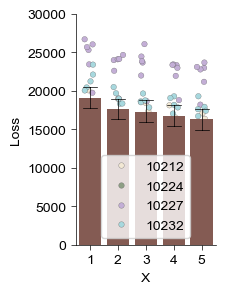

  Mean: 19097.17705864703, STD: 3756.5652835948117, Max: 26681.38241978974, Min: 14067.469319560534, Median: 17963.358949328613, df: 27
  Mean: 17645.59196002544, STD: 3559.035807878876, Max: 24646.490926400566, Min: 12774.865382591095, Median: 16820.477007505364, df: 27
  Mean: 17241.703707468874, STD: 3800.33401088026, Max: 26054.939248470637, Min: 12147.723834350203, Median: 15999.981269175718, df: 27
TtestResult(statistic=-13.545573460368054, pvalue=1.4786427968127594e-13, df=27)
TtestResult(statistic=3.61563361061007, pvalue=0.0012118704175404823, df=27)

D Loss
  Mean: 1451.585098621589, STD: 556.8355927518235, Max: 2909.7910255255047, Min: 654.9990546004483, Median: 1449.92776596779, df: 27
  Mean: 403.88825255656747, STD: 580.4418113234781, Max: 1617.1539868672135, Min: -1408.4483220700713, Median: 520.0503938425009, df: 27
TtestResult(statistic=6.332823925517884, pvalue=8.844572701928314e-07, df=27)
TtestResult(statistic=-0.4335930383190982, pvalue=0.6680287207383837, df=27)


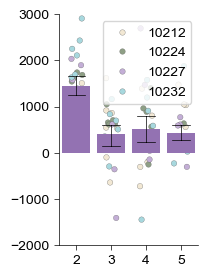

In [5]:

from sklearn.metrics import silhouette_score
def select_best_rank(X, session_label, max_rank: int, kmeans_init='k-means++'):
    """
    Uses silhouette_scores to select the best rank R for low-rank matrix factorization.

    Parameters:
        X: ndarray (I x J x K) tensor of normalized firing rates
        k_clusters: int, number of clusters
        max_rank: int, maximum rank R to test

    Returns:
        best_R: int, the rank R with the lowest silhouette_scores score
        silhouette_scores: list, silhouette_scores scores for each tested rank
    """
    I, J, K = X.shape
    n = I  # Number of samples (rows in U_continuous)
    silhouette_scores = np.zeros((7, max_rank))
    average_loss = np.zeros((7, max_rank))

    for rank_R in range(1, max_rank + 1):
        X_wrap = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
        for i in range(7):
            if rank_R == 2:
                U, V, kmeans = fit_kmeans(
                    X[session_label == i, :, :], rank_R, 
                    kmeans_init=kmeans_init, 
                    is_return_model=True
                )
            else:
                U, V, kmeans = fit_kmeans(
                    X[session_label == i, :, :], 
                    rank_R, 
                    is_return_model=True
                )

            loss = np.mean(np.sum(np.square(X_wrap[session_label == i, :] - U @ V), axis=1))
            average_loss[i, rank_R - 1] = loss
        
            if rank_R == 1:
                silhouette_scores[i, rank_R - 1] = np.nan
                continue
            
            labels = kmeans.labels_
    
            silhouette_scores[i, rank_R - 1] = silhouette_score(
                X_wrap[session_label == i, :], 
                labels
            )
       
    return silhouette_scores.flatten(), average_loss.flatten()

if exists(join(figdata, f"{code_id} [silhouette_scores].pkl")) == False:
    EffData = {
        "MiceID": [],
        "Session": [],
        "Loss": [],
        "X": [],
        "silhouette_scores": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        if exists(join(loc, f"{mouse}.pkl")) == False:
            X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
            
            with open(join(loc, f"{mouse}.pkl"), "wb") as f:
                pickle.dump([X, session_label, route_label, kmeans_init], f)
        else:
            with open(join(loc, f"{mouse}.pkl"), "rb") as f:
                X, session_label, route_label, kmeans_init = pickle.load(f)
        
        kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
        silhouette_scores, average_loss = select_best_rank(X, session_label, 5, kmeans_init=kmeans_init)
        EffData["MiceID"].append(np.repeat(mouse, 5 * 7))
        EffData["X"].append(np.concatenate([np.arange(1, 6)] * 7))
        EffData["silhouette_scores"].append(silhouette_scores)
        EffData["Loss"].append(average_loss)
        EffData["Session"].append(np.repeat([1, 2, 3, 4, 5], 7))
        
        #U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
        #plot_lapwise_distances(X, session_label, route_label, mouse, kmeans_init=kmeans_init)
        #plot_pca_clusters(X, session_label, route_label, mouse, U[:, 1])
        
    for k in EffData.keys():
        EffData[k] = np.concatenate(EffData[k])
        
    with open(join(figdata, f"{code_id} [silhouette_scores].pkl"), "wb") as f:
        pickle.dump(EffData, f)
        
    EffD = pd.DataFrame(EffData)
    EffD.to_excel(join(figdata, f"{code_id} [silhouette_scores].xlsx"), index = False)
else:
    with open(join(figdata, f"{code_id} [silhouette_scores].pkl"), "rb") as f:
        EffData = pickle.load(f)
        
fig = plt.figure(figsize=(1.8, 3))
SubData = SubDict(EffData, EffData.keys(), np.where(EffData['X'] != 1)[0])
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'X',
    y='silhouette_scores',
    data=SubData,
    hue='MiceID',
    palette = ['#F2E8D4', '#8E9F85', '#C3AED6', '#A7D8DE'],
    size = 4,
    linewidth=0.2,
    jitter=0.2,
    ax = ax,
    zorder=1
)
sns.barplot(
    x = 'X',
    y='silhouette_scores',
    data=SubData,
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(-0.02, 0.18)
ax.set_yticks(np.linspace(-0.02, 0.18, 11))
plt.savefig(join(loc, "silhouette_scores.png"), dpi=600)
plt.savefig(join(loc, "silhouette_scores.svg"), dpi=600)
plt.show()

idx1 = np.where(EffData["X"] == 1)[0]
idx2 = np.where(EffData["X"] == 2)[0]
idx3 = np.where(EffData["X"] == 3)[0]
print_estimator(EffData["silhouette_scores"][idx2])
print_estimator(EffData["silhouette_scores"][idx3])
print(ttest_rel(EffData["silhouette_scores"][idx2], EffData["silhouette_scores"][idx3]))

fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'X',
    y='Loss',
    data=EffData,
    hue='MiceID',
    palette = ['#F2E8D4', '#8E9F85', '#C3AED6', '#A7D8DE'],
    size = 4,
    linewidth=0.2,
    jitter=0.2,
    ax = ax,
    zorder=1
)
sns.barplot(
    x = 'X',
    y='Loss',
    data=EffData,
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(0, 30000)
plt.savefig(join(loc, "Loss.png"), dpi=600)
plt.savefig(join(loc, "Loss.svg"), dpi=600)
plt.show()

print_estimator(EffData["Loss"][idx1])
print_estimator(EffData["Loss"][idx2])
print_estimator(EffData["Loss"][idx3])
print(ttest_rel(EffData["Loss"][idx2], EffData["Loss"][idx1]))
print(ttest_rel(EffData["Loss"][idx2], EffData["Loss"][idx3]), end='\n\n')

x, y, m = [], [], []
for i in range(2, 6):
    idxa = np.where(EffData["X"] == i-1)[0]
    idxb = np.where(EffData["X"] == i)[0]
    x.append(np.repeat(i, idxa.shape[0]))
    y.append(EffData["Loss"][idxa] - EffData["Loss"][idxb])
    m.append(EffData["MiceID"][idxa])
    
print("D Loss")
print_estimator(y[0])
print_estimator(y[1])
print(ttest_rel(y[0], y[1]))
print(ttest_rel(y[1], y[2]))
x, y, m = np.concatenate(x), np.concatenate(y), np.concatenate(m)

fig = plt.figure(figsize=(1.8, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = x,
    y= y,
    hue=m,
    palette = ['#F2E8D4', '#8E9F85', '#C3AED6', '#A7D8DE'],
    size = 4,
    linewidth=0.2,
    jitter=0.2,
    ax = ax,
    zorder=1
)
sns.barplot(
    x = x,
    y= y,
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(-2000, 3000)
ax.set_yticks(np.linspace(-2000, 3000, 6))
plt.savefig(join(loc, "Loss_diff.png"), dpi=600)
plt.savefig(join(loc, "Loss_diff.svg"), dpi=600)
plt.show()



# Identify Map Cross Day Stability

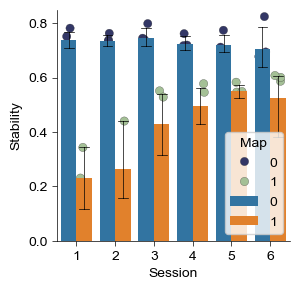

Cross Map Comparison
Session 1->2:  TtestResult(statistic=nan, pvalue=nan, df=nan)
  Mean: 0.23027962867100937, STD: 0.09230036104298076, Max: 0.3432373560402956, Min: 0.11714876728397801, Median: 0.23045276268875456, df: 3

Session 2->3:  TtestResult(statistic=nan, pvalue=nan, df=nan)
  Mean: 0.26443457604481274, STD: 0.12548433235608217, Max: 0.4403217394336972, Min: 0.15606415375921606, Median: 0.196917834941525, df: 3

Session 3->4:  TtestResult(statistic=6.035592570271955, pvalue=0.009119577053490686, df=3)
  Mean: 0.4280506216928194, STD: 0.11321088375466726, Max: 0.5514794664981677, Min: 0.29561401825833655, Median: 0.4325545010073866, df: 3

Session 4->5:  TtestResult(statistic=6.669734362124063, pvalue=0.00687179941870612, df=3)
  Mean: 0.49507575509513846, STD: 0.06871203985682764, Max: 0.5778362416224251, Min: 0.4130264106749767, Median: 0.49472018404157614, df: 3

Session 5->6:  TtestResult(statistic=5.4498788951817705, pvalue=0.012134569626111246, df=3)
  Mean: 0.549299624

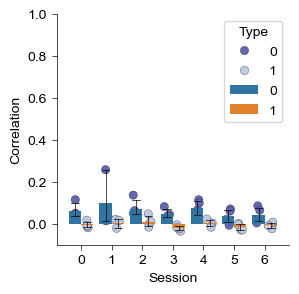

  Mean: 0.06108907975360725, STD: 0.051453325840761434, Max: 0.2572168375473515, Min: -0.0072599529579730655, Median: 0.049590772093649024, df: 27
TtestResult(statistic=nan, pvalue=nan, df=nan)

Map 1 vs. Map 2 - Across Day
F_onewayResult(statistic=nan, pvalue=nan)


In [5]:
def get_cross_day_stability(mouse):
    if exists(join(loc, f"{mouse}.pkl")) == False:
        X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
        
        with open(join(loc, f"{mouse}.pkl"), "wb") as f:
            pickle.dump([X, session_label, route_label, kmeans_init], f)
    else:
        with open(join(loc, f"{mouse}.pkl"), "rb") as f:
            X, session_label, route_label, kmeans_init = pickle.load(f)
    
    kmeans_init = np.vstack([
        np.mean(i, axis=0) for i in kmeans_init
    ])
    US, VS = [], []
    for i in range(7):
        U, V = fit_kmeans(X[session_label == i, :, :], 2, kmeans_init=kmeans_init)
        US.append(U)
        VS.append(V)
    
    A = np.concatenate(US, axis=0)
    print(A.shape[0], np.sum(A[:, 0]), np.sum(A[:, 1]))
    
    stability = np.zeros((2, 6))
    for i in range(6):
        stability[0, i] = np.corrcoef(VS[i][0, :], VS[i+1][0, :])[0, 1]
        stability[1, i] = np.corrcoef(VS[i][1, :], VS[i+1][1, :])[0, 1]
    return stability.T

def get_cross_map_correlation(mouse):
    if exists(join(loc, f"{mouse}.pkl")) == False:
        X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
        
        with open(join(loc, f"{mouse}.pkl"), "wb") as f:
            pickle.dump([X, session_label, route_label, kmeans_init], f)
    else:
        with open(join(loc, f"{mouse}.pkl"), "rb") as f:
            X, session_label, route_label, kmeans_init = pickle.load(f)
    
    kmeans_init = np.vstack([
        np.mean(i, axis=0) for i in kmeans_init
    ])
    US, VS = [], []
    for i in range(7):
        U, V = fit_kmeans(X[session_label == i, :, :], 2, kmeans_init=kmeans_init)
        US.append(U)
        VS.append(V)
        
    stability = np.zeros(14)
    for i in range(7):
        stability[i] = np.corrcoef(VS[i][0, :], VS[i][1, :])[0, 1]
        stability[i+7] = np.corrcoef(VS[i][0, :], VS[i][1, np.random.permutation(VS[i][0, :].shape[0])])[0, 1]
        
        
    return stability

if exists(join(figdata, f"{code_id} [cross_day_stability].pkl")) == False:
    StabData = {
        "MiceID": [],
        "Stability": [],
        "Session": [],
        "Map": [],
    }
    
    BetCorrData = {
        "MiceID": [],
        "Correlation": [],
        "Session": [],
        "Type": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        stability = get_cross_day_stability(mouse)
        StabData["MiceID"].append(np.repeat(mouse, 12))
        StabData["Stability"].append(stability.flatten())
        StabData["Session"].append(np.repeat([1, 2, 3, 4, 5, 6], 2))
        StabData["Map"].append(np.concatenate([np.array([0, 1])]*6))
        
        corr = get_cross_map_correlation(mouse)
        BetCorrData["MiceID"].append(np.repeat(mouse, 14))
        BetCorrData["Correlation"].append(corr)
        BetCorrData["Session"].append(np.concatenate([np.arange(7), np.arange(7)]))
        BetCorrData["Type"].append(np.concatenate([np.repeat(0, 7), np.repeat(1, 7)]))
        
    for k in StabData.keys():
        StabData[k] = np.concatenate(StabData[k])
    
    for k in BetCorrData.keys():
        BetCorrData[k] = np.concatenate(BetCorrData[k])
        
    with open(join(figdata, f"{code_id} [cross_day_stability].pkl"), "wb") as f:
        pickle.dump(StabData, f)
        
    with open(join(figdata, f"{code_id} [cross_map_correlation].pkl"), "wb") as f:
        pickle.dump(BetCorrData, f)
        
    StabD = pd.DataFrame(StabData)
    StabD.to_excel(join(figdata, f"{code_id} [cross_day_stability].xlsx"), index = False)
    
    BetCorrD = pd.DataFrame(BetCorrData)
    BetCorrD.to_excel(join(figdata, f"{code_id} [cross_map_correlation].xlsx"), index = False)
    
    print(len(StabD), len(BetCorrD))
else:
    with open(join(figdata, f"{code_id} [cross_day_stability].pkl"), "rb") as f:
        StabData = pickle.load(f)
        
    with open(join(figdata, f"{code_id} [cross_map_correlation].pkl"), "rb") as f:
        BetCorrData = pickle.load(f)
        
fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Session',
    y='Stability',
    data=StabData,
    hue='Map',
    palette = ['#333766', '#A4C096'],
    size = 6,
    linewidth=0.2,
    dodge=True,
    jitter=0.2,
    ax = ax,
    zorder=1
)

sns.barplot(
    x = 'Session',
    y='Stability',
    data=StabData,
    hue='Map',
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(0, 0.85)
plt.savefig(join(loc, "Cross Day Stability.png"), dpi=600)
plt.savefig(join(loc, "Cross Day Stability.svg"), dpi=600)
plt.show()

print("Cross Map Comparison")
for s in range(1, 7):
    res = ttest_rel(
        StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 0))[0]],
        StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 1))[0]]
    )
    print(f"Session {s}->{s+1}:  {res}")
    print_estimator(StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 1))[0]], end='\n\n')

print("Map 0 Stability Overall:")
print_estimator(StabData['Stability'][np.where((StabData['Map'] == 0))[0]])

map_stab0 = [
    StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 0))[0]] for s in range(1, 7)
]
map_stab1 = [
    StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 1))[0]] for s in range(1, 7)
]

print("\nCross Day Comparison")
print(f"  Map 0: {f_oneway(*map_stab0)}")
print(f"  Map 1: {f_oneway(*map_stab1)}")


fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Session',
    y = 'Correlation',
    data=BetCorrData,
    hue='Type',
    palette = ['#6467b1', '#becae1'],
    size = 6,
    linewidth=0.2,
    dodge=True,
    jitter=0.2,
    edgecolor='k',
    ax = ax,
    zorder=1
)

sns.barplot(
    x = 'Session',
    y = 'Correlation',
    data=BetCorrData,
    hue='Type',
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(-0.1, 1)
ax.set_xlim(-0.8, 6.8)
plt.savefig(join(loc, "Cross Map Correlation.png"), dpi=600)
plt.savefig(join(loc, "Cross Map Correlation.svg"), dpi=600)
plt.show()

idx0 = np.where(BetCorrData['Type'] == 0)[0]
idx1 = np.where(BetCorrData['Type'] == 1)[0]
print_estimator(BetCorrData['Correlation'][idx0])
print(ttest_rel(BetCorrData['Correlation'][idx0], BetCorrData['Correlation'][idx1]), end='\n\n')

print("Map 1 vs. Map 2 - Across Day")
map_stab2 = [
    BetCorrData['Correlation'][np.where((BetCorrData['Session'] == s) & (BetCorrData['Type'] == 0))[0]] for s in range(7)
]
print(f_oneway(*map_stab2))

# Second Version

Cross Session Comparison
Session 1->2:  TtestResult(statistic=9.507107075030744, pvalue=0.01088348316021514, df=2)
  Mean: 0.23027962867100937, STD: 0.09230036104298076, Max: 0.3432373560402956, Min: 0.11714876728397801, Median: 0.23045276268875456, df: 3

Session 2->3:  TtestResult(statistic=5.2657305804823515, pvalue=0.034224055945900875, df=2)
  Mean: 0.26443457604481274, STD: 0.12548433235608217, Max: 0.4403217394336972, Min: 0.15606415375921606, Median: 0.196917834941525, df: 3

Session 3->4:  TtestResult(statistic=6.035592570271955, pvalue=0.009119577053490686, df=3)
  Mean: 0.4280506216928194, STD: 0.11321088375466726, Max: 0.5514794664981677, Min: 0.29561401825833655, Median: 0.4325545010073866, df: 3

Session 4->5:  TtestResult(statistic=6.669734362124063, pvalue=0.00687179941870612, df=3)
  Mean: 0.49507575509513846, STD: 0.06871203985682764, Max: 0.5778362416224251, Min: 0.4130264106749767, Median: 0.49472018404157614, df: 3

Session 5->6:  TtestResult(statistic=5.4498788951

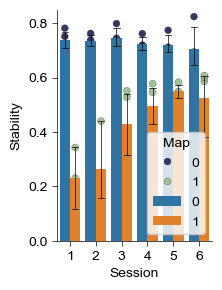

Map 0 Stability Overall:
  Mean: 0.7286756023833741, STD: 0.04162601740421432, Max: 0.8246885008842905, Min: 0.6284770871811497, Median: 0.7188480557718436, df: 23

Cross Day Comparison
  Map 0: F_onewayResult(statistic=0.4180171282956076, pvalue=0.8300647276152454)
  Map 1: F_onewayResult(statistic=4.793522545065603, pvalue=0.007220602123342669)


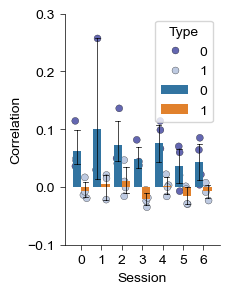

  Mean: 0.06108907975360725, STD: 0.05145332584076143, Max: 0.2572168375473515, Min: -0.0072599529579730655, Median: 0.049590772093649024, df: 26
TtestResult(statistic=7.279729798052283, pvalue=9.89770715847403e-08, df=26)

Map 1 vs. Map 2 - Across Day
F_onewayResult(statistic=0.5643254707632666, pvalue=0.7536165326118491)


In [7]:
def get_cross_day_stability(mouse):
    if exists(join(loc, f"{mouse}.pkl")) == False:
        X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
        
        with open(join(loc, f"{mouse}.pkl"), "wb") as f:
            pickle.dump([X, session_label, route_label, kmeans_init], f)
    else:
        with open(join(loc, f"{mouse}.pkl"), "rb") as f:
            X, session_label, route_label, kmeans_init = pickle.load(f)
    
    kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
    U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
    M0, M1 = np.zeros((7, X.shape[1]*X.shape[2])), np.zeros((7, X.shape[1]*X.shape[2]))
    for i in range(7):
        idx0 = np.where((session_label == i) & (U[:, 0] == 1))[0]
        idx1 = np.where((session_label == i) & (U[:, 1] == 1))[0]
        M0[i, :] = np.mean(X[idx0, :, :].reshape(idx0.shape[0], X.shape[1]*X.shape[2]), axis=0)
        M1[i, :] = np.mean(X[idx1, :, :].reshape(idx1.shape[0], X.shape[1]*X.shape[2]), axis=0)

    stability = np.zeros((2, 6))
    for i in range(6):
        stability[0, i] = np.corrcoef(M0[i, :], M0[i+1, :])[0, 1]
        stability[1, i] = np.corrcoef(M1[i, :], M1[i+1, :])[0, 1]
    return stability.T

def get_cross_map_correlation(mouse):
    if exists(join(loc, f"{mouse}.pkl")) == False:
        X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
        
        with open(join(loc, f"{mouse}.pkl"), "wb") as f:
            pickle.dump([X, session_label, route_label, kmeans_init], f)
    else:
        with open(join(loc, f"{mouse}.pkl"), "rb") as f:
            X, session_label, route_label, kmeans_init = pickle.load(f)
    
    kmeans_init = np.vstack([np.mean(i, axis=0) for i in kmeans_init])
    U, V = fit_kmeans(X, 2, kmeans_init=kmeans_init)
    M0, M1 = np.zeros((7, X.shape[1]*X.shape[2])), np.zeros((7, X.shape[1]*X.shape[2]))
    M_Shuf0 = np.zeros((7, X.shape[1]*X.shape[2]))
    M_Shuf1 = np.zeros((7, X.shape[1]*X.shape[2]))
    for i in range(7):
        idx0 = np.where((session_label == i) & (U[:, 0] == 1))[0]
        idx1 = np.where((session_label == i) & (U[:, 1] == 1))[0]
        M0[i, :] = np.mean(X[idx0, :, :].reshape(idx0.shape[0], X.shape[1]*X.shape[2]), axis=0)
        M1[i, :] = np.mean(X[idx1, :, :].reshape(idx1.shape[0], X.shape[1]*X.shape[2]), axis=0)
        M_Shuf0[i, :] = np.mean(X[:, :, np.random.permutation(X.shape[2])].reshape(X.shape[0], X.shape[1]*X.shape[2])[idx0, :], axis=0)
        M_Shuf1[i, :] = np.mean(X[:, :, np.random.permutation(X.shape[2])].reshape(X.shape[0], X.shape[1]*X.shape[2])[idx1, :], axis=0)

    stability = np.zeros(14)
    for i in range(7):
        stability[i] = np.corrcoef(M0[i, :], M1[i, :])[0, 1]
        stability[i+7] = np.corrcoef(M_Shuf0[i, :], M_Shuf1[i, :])[0, 1]

    return stability

if exists(join(figdata, f"{code_id} [cross_day_stability].pkl")) == False:
    StabData = {
        "MiceID": [],
        "Stability": [],
        "Session": [],
        "Map": [],
    }
    
    BetCorrData = {
        "MiceID": [],
        "Correlation": [],
        "Session": [],
        "Type": []
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        stability = get_cross_day_stability(mouse)
        StabData["MiceID"].append(np.repeat(mouse, 12))
        StabData["Stability"].append(stability.flatten())
        StabData["Session"].append(np.repeat([1, 2, 3, 4, 5, 6], 2))
        StabData["Map"].append(np.concatenate([np.array([0, 1])]*6))
        
        corr = get_cross_map_correlation(mouse)
        BetCorrData["MiceID"].append(np.repeat(mouse, 14))
        BetCorrData["Correlation"].append(corr)
        BetCorrData["Session"].append(np.concatenate([np.arange(7), np.arange(7)]))
        BetCorrData["Type"].append(np.concatenate([np.repeat(0, 7), np.repeat(1, 7)]))
        
    for k in StabData.keys():
        StabData[k] = np.concatenate(StabData[k])
    
    for k in BetCorrData.keys():
        BetCorrData[k] = np.concatenate(BetCorrData[k])
        
    with open(join(figdata, f"{code_id} [cross_day_stability].pkl"), "wb") as f:
        pickle.dump(StabData, f)
        
    with open(join(figdata, f"{code_id} [cross_map_correlation].pkl"), "wb") as f:
        pickle.dump(BetCorrData, f)
        
    StabD = pd.DataFrame(StabData)
    StabD.to_excel(join(figdata, f"{code_id} [cross_day_stability].xlsx"), index = False)
    
    BetCorrD = pd.DataFrame(BetCorrData)
    BetCorrD.to_excel(join(figdata, f"{code_id} [cross_map_correlation].xlsx"), index = False)
    
    print(len(StabD), len(BetCorrD))
else:
    with open(join(figdata, f"{code_id} [cross_day_stability].pkl"), "rb") as f:
        StabData = pickle.load(f)
        
    with open(join(figdata, f"{code_id} [cross_map_correlation].pkl"), "rb") as f:
        BetCorrData = pickle.load(f)
        
fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Session',
    y='Stability',
    data=StabData,
    hue='Map',
    palette = ['#333766', '#A4C096'],
    size = 5,
    linewidth=0.2,
    dodge=True,
    jitter=0,
    ax = ax,
    zorder=1
)

sns.barplot(
    x = 'Session',
    y='Stability',
    data=StabData,
    hue='Map',
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(0, 0.85)


print("Cross Session Comparison")
for s in range(1, 7):
    idx0 = np.where((StabData['Session'] == s) & (StabData['Map'] == 0))[0]
    idx1 = np.where((StabData['Session'] == s) & (StabData['Map'] == 1))[0]
    nonnan_idx = np.where((np.isnan(StabData['Stability'][idx0]) == False) &
                          (np.isnan(StabData['Stability'][idx1]) == False))[0]
    
    res = ttest_rel(
        StabData['Stability'][idx0[nonnan_idx]],
        StabData['Stability'][idx1[nonnan_idx]]
    )
    print(f"Session {s}->{s+1}:  {res}")
    print_estimator(StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 1))[0]], end='\n\n')
    """
    for k in nonnan_idx:
        ax.plot(
            [s-1.2, s-0.8],
            [StabData['Stability'][idx0[k]], StabData['Stability'][idx1[k]]],
            linewidth=0.5,
            color='k'
        )
    """
plt.savefig(join(loc, "Cross Day Stability.png"), dpi=600)
plt.savefig(join(loc, "Cross Day Stability.svg"), dpi=600)
plt.show()

print("Map 0 Stability Overall:")
print_estimator(StabData['Stability'][np.where((StabData['Map'] == 0))[0]])

map_stab0 = [
    StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 0) & (np.isnan(StabData['Stability']) == False))[0]] for s in range(1, 7)
]
map_stab1 = [
    StabData['Stability'][np.where((StabData['Session'] == s) & (StabData['Map'] == 1) & (np.isnan(StabData['Stability']) == False))[0]] for s in range(1, 7)
]

print("\nCross Day Comparison")
print(f"  Map 0: {f_oneway(*map_stab0)}")
print(f"  Map 1: {f_oneway(*map_stab1)}")


fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Session',
    y = 'Correlation',
    data=BetCorrData,
    hue='Type',
    palette = ['#6467b1', '#becae1'],
    size = 5,
    linewidth=0.2,
    dodge=True,
    jitter=0.2,
    edgecolor='k',
    ax = ax,
    zorder=1
)

sns.barplot(
    x = 'Session',
    y = 'Correlation',
    data=BetCorrData,
    hue='Type',
    ax = ax,
    zorder=2,
    capsize=0.5,
    linewidth=0.5,
    width=0.8,
    err_kws={"color": 'k', 'linewidth': 0.5}
)
ax.set_ylim(-0.1, 0.3)
ax.set_yticks(np.linspace(-0.1, 0.3, 5))
ax.set_xlim(-0.8, 6.8)
plt.savefig(join(loc, "Cross Map Correlation.png"), dpi=600)
plt.savefig(join(loc, "Cross Map Correlation.svg"), dpi=600)
plt.show()

idx0 = np.where(BetCorrData['Type'] == 0)[0]
idx1 = np.where(BetCorrData['Type'] == 1)[0]
nan_idx = np.where((np.isnan(BetCorrData['Correlation'][idx0]) == False)&(np.isnan(BetCorrData['Correlation'][idx1]) == False))[0]
print_estimator(BetCorrData['Correlation'][idx0[nan_idx]])
print(ttest_rel(BetCorrData['Correlation'][idx0[nan_idx]], BetCorrData['Correlation'][idx1[nan_idx]]), end='\n\n')

print("Map 1 vs. Map 2 - Across Day")
map_stab2 = [
    BetCorrData['Correlation'][np.where(
        (BetCorrData['Session'] == s) & 
        (BetCorrData['Type'] == 0) & 
        (np.isnan(BetCorrData['Correlation']) == False)
    )[0]] for s in range(7)
]
print(f_oneway(*map_stab2))

# Sudden Transition or gradual Transition

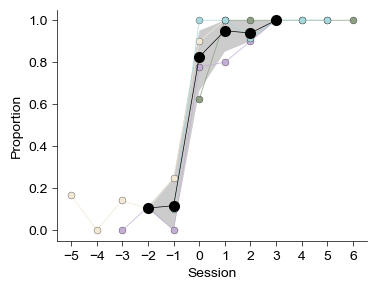

In [8]:
data = {
    "MiceID": sum([[mouse]*7 for mouse in [10212, 10224, 10227, 10232]], []),
    "Session": [-5, -4, -3, -2, -1, 0, 1,
                0, 1, 2, 3, 4, 5, 6,
                -3, -2, -1, 0, 1, 2, 3,
                -1, 0, 1, 2, 3, 4, 5
                ],
    "Proportion": [1/6, 0/6, 1/7, 1/10, 1/4, 9/10, 10/10,
                   5/8, 1, 1, 1, 1, 1, 1,
                   0/8, 1/9, 0/9, 7/9, 8/10, 9/10, 1,
                   1/10, 1, 1, 11/12, 1, 1, 1],
    # Transition Time / (Lap Num - 1)
    "Transition Frequency": [1, 0, 2, 1, 3, 2, 0,
                             1, 0, 0, 0, 0, 0, 0,
                             0, 2, 0, 4, 3, 2, 0,
                             2, 0, 0, 2, 0, 0, 0],
    "Lap Number-1": [6-1, 6-1, 7-1, 10-1, 10-1, 8-1, 10-1, 
          8-1, 9-1, 10-1, 10-1, 13-1, 10-1, 10-1,
          8-1, 9-1, 9-1, 9-1, 10-1, 10-1, 9-1,
          10-1, 10-1, 10-1, 11-1, 12-1, 12-1, 14-1],
}
# These data are manually counted from Figure 3C and related extended Figures.

for k in data.keys():
    data[k] = np.array(data[k])

fig = plt.figure(figsize=(4, 3))
SubData = SubDict(data, data.keys(), np.where(np.isin(data['Session'], [-2, -1, 0, 1, 2, 3]))[0])
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
for i in range(4):
    ax.plot(
        data['Session'][i*7:(i+1)*7],
        data['Proportion'][i*7:(i+1)*7],
        linewidth=0.5,
        marker='o',
        markersize=5,
        markeredgewidth=0.2,
        markeredgecolor='k',
        color=MicePaletteDSP[i],
    )
sns.lineplot(
    x = 'Session',
    y = 'Proportion',
    data = SubData,
    linewidth = 0.5,
    marker='o',
    markeredgewidth=0,
    markersize=8,
    color = 'k',
    err_kws={"edgecolor": None},
    ax = ax,
    legend=False
)
ax.set_xticks(np.arange(-5, 7))
plt.savefig(join(loc, "Map Switching Proportion.png"), dpi=600)
plt.savefig(join(loc, "Map Switching Proportion.svg"), dpi=600)
plt.show()

# Freqency of Transition Peaks Around Transition Session

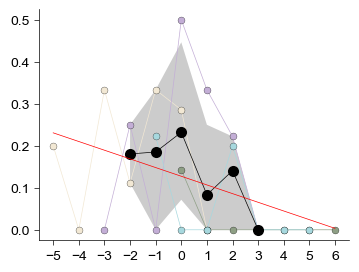

Transition Frequency: -0.021 * Session + 0.127, p = 0.037


In [35]:

x = np.arange(-5, 7)
transition_times = np.zeros_like(x)
lap_numbers = np.zeros_like(x)
for i in range(-5, 7):
    idx = np.where(data['Session'] == i)[0]
    if idx.size > 0:
        transition_times[i+5] = np.sum(data['Transition Frequency'][idx])
        lap_numbers[i+5] = np.sum(data['Lap Number-1'][idx])
    
fig = plt.figure(figsize=(4, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
SubData = SubDict(data, data.keys(), np.where(np.isin(data['Session'], [-2, -1, 0, 1, 2, 3]))[0])
for i in range(4):
    ax.plot(
        data['Session'][i*7:(i+1)*7],
        data['Transition Frequency'][i*7:(i+1)*7]/data['Lap Number-1'][i*7:(i+1)*7],
        linewidth=0.5,
        marker='o',
        markersize=5,
        markeredgewidth=0.2,
        markeredgecolor='k',
        color=MicePaletteDSP[i],
    )
sns.lineplot(
    x = SubData['Session'],
    y = SubData['Transition Frequency']/SubData['Lap Number-1'],
    data = SubData,
    linewidth = 0.5,
    marker='o',
    markeredgewidth=0,
    markersize=8,
    color = 'k',
    err_kws={"edgecolor": None},
    ax = ax,
    legend=False
)
res = linregress(data['Session'], data['Transition Frequency']/data['Lap Number-1'])
x = np.linspace(-5, 6, 2)
y = res.slope * x + res.intercept
ax.plot(x, y, color='r', linewidth=0.5)
ax.set_xticks(np.arange(-5, 7))
plt.savefig(join(loc, "Map Swing Frequency.png"), dpi=600)
plt.savefig(join(loc, "Map Swing Frequency.svg"), dpi=600)
plt.show()
print(f"Transition Frequency: {res.slope:.3f} * Session + {res.intercept:.3f}, p = {res.pvalue:.3f}")

# All Bins

In [2]:
from mylib.statistic_test import *
from sklearn.decomposition import PCA
from mazepy.datastruc.neuact import SpikeTrain
from mazepy.datastruc.variables import VariableBin

code_id = "0850 - Lisa Paper Revisits"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

def get_lapwise_ratemap_allbin(trace: dict, is_cutted: bool = True):    
    maze_type = trace['maze_type']
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx, maze_type)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    
    for i in range(beg_idx.shape[0]):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() #@ trace['Ms'].T
        
        smoothed_map[:, :, i] /= (np.max(smoothed_map[:, :, i], axis=1, keepdims=True) + 1e-12)
    
    if is_cutted:
        bins = CP_DSPs[maze_type][0]-1
        smoothed_map = smoothed_map[:, bins, :]

    X = np.transpose(smoothed_map, (2, 1, 0))
    return X

def get_all_mice_data_allbin(mouse):
    file_indices = np.where(f2['MiceID'] == mouse)[0]
    cellreg_index = np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]
    
    traces = []
    for i in file_indices:
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
            traces.append(trace)

    with open(f_CellReg_dsp['cellreg_folder'][cellreg_index], 'rb') as handle:
        index_map = pickle.load(handle).astype(np.int64)
            
    if mouse != 10232:
        index_map = index_map[1:, :]
    
    # Identify neurons that appear in all sessions
    ncell = np.where(np.sum(np.where(index_map == 0, 0, 1), axis=0) == index_map.shape[0])[0]
    
    session_label = []
    route_label = []
    Xs = []

    for i, trace in tqdm(enumerate(traces)):
        X = get_lapwise_ratemap_allbin(trace)
        
        beg_time, end_time = trace['lap beg time'], trace['lap end time']
        beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx, trace['maze_type'])
        Xs.append(X[:, :, index_map[i, ncell]-1])
        
        session_label.append(np.ones(X.shape[0])*i)
        route_label.append(routes)
    
    return np.concatenate(Xs, axis=0), np.concatenate(session_label), np.concatenate(route_label)

smoothed_map, session_label, route_label = get_all_mice_data_allbin(10232)

        D:\Data\FinalResults\Dsp\0850 - Lisa Paper Revisits is already existed!


0it [00:00, ?it/s]d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
7it [00:04,  1.61it/s]


In [1]:
from mylib.statistic_test import *
from sklearn.cluster import KMeans
import os

os.environ['OMP_NUM_THREADS'] = '1'

is_r1 = np.where(route_label == 0, 1, 0)
PCs = np.zeros((smoothed_map.shape[0], smoothed_map.shape[1])) * np.nan
for i in range(smoothed_map.shape[1]):
    rts = [0]
    for rt in range(1, 7):
        if CP_DSPs[1][0][i] in CP_DSPs[1][rt]:
            rts.append(rt)
                
    init_rt = 0
    for rt in [4, 1, 5, 2, 6, 3]:
        if rt in rts:
            init_rt = rt
                
    idx = np.where(np.isin(route_label, rts))[0]
        
    corr = np.corrcoef(smoothed_map[idx, i, :])
    fig = plt.figure(figsize=(3, 3))
    ax = Clear_Axes(plt.axes())
    ax.imshow(corr, cmap='bwr', vmin=0, vmax=0.5)
    plt.show()


d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'route_label' is not defined

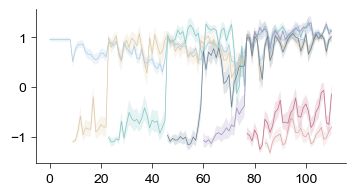

In [57]:
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x=np.tile(np.arange(PCs.shape[1]), (PCs.shape[0], 1)).flatten(),
    y=PCs.flatten(),
    linewidth=0.5,
    err_kws={"edgecolor": None},
    ax = ax,
    hue=np.tile(route_label[:, np.newaxis], (1, smoothed_map.shape[1])).flatten(),
    hue_order=[0, 1, 2, 3, 4, 5, 6],
    palette=DSPPalette[:-1],
    legend=False
)
plt.show()